## Initialization

In [2]:
from scm.simple_active_learning import SimpleActiveLearningJob
import scm.plams as plams
import matplotlib.pyplot as plt
import os

plams.init(folder="plams_workdir_continuation")

PLAMS working folder: /home/hellstrom/adfhome/userdoc/Workflows/SimpleActiveLearning/PythonExamples/SALContinueWithNewSystem/plams_workdir_continuation.002


Set the correct path to the previous Simple Active Learning job. The path should be a directory containing the file "simple_active_learning.rkf"

In [3]:
# replace the path with your own path !
previous_sal_job_path = os.path.expandvars("$AMSHOME/examples/SAL/Output/SingleMolecule/plams_workdir/sal")
previous_sal_job = SimpleActiveLearningJob.load_external(previous_sal_job_path)
previous_params_path = previous_sal_job.results.get_params_results_directory()

## Initial system, reference engine settings, MD settings

These settings were explained in the first tutorial.

Here we use a new molecule (acetic acid), but we could also have changed the temperature of the MD simulation, or any other setting.

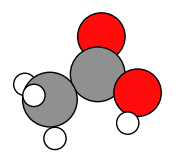

In [3]:
mol = plams.from_smiles("CC(O)=O")
for at in mol:
    at.properties = {}
mol = plams.preoptimize(mol)
plams.plot_molecule(mol)

In [4]:
ref_s = plams.Settings()
ref_s.input.ForceField.Type = "UFF"
ref_s.runscript.nproc = 1

In [5]:
md_s = plams.AMSNVTJob(temperature=300, timestep=0.5, nsteps=10000).settings

## ParAMS ML training settings
Here we set ``LoadModel = previous_params_path`` to load the model from the previous job.

This will also automatically load the previous training and validation data, unless it's disabled in the Active Learning settings.

In [6]:
ml_s = plams.Settings()
ml_s.input.ams.MachineLearning.Backend = "M3GNet"
ml_s.input.ams.MachineLearning.CommitteeSize = 1
ml_s.input.ams.MachineLearning.LoadModel = os.path.abspath(previous_params_path)
ml_s.input.ams.MachineLearning.MaxEpochs = 200

## Active Learning settings

Here we use the same settings as before, but if the system is similar (or even the same!) as before, you may consider increasing the ``Start`` to let the system evolve a bit more before the first reference calculation.

You can also set the``ActiveLearning.InitialReferenceData.Load.Directory`` option instead of the ``MachineLearning.LoadModel`` option to load the data from the previous run. See the documentation for details about the difference between the two options.

In [9]:
al_s = plams.Settings()
al_s.input.ams.ActiveLearning.Steps.Type = "Geometric"
al_s.input.ams.ActiveLearning.Steps.Geometric.Start = 10  # 10 MD frames
al_s.input.ams.ActiveLearning.Steps.Geometric.NumSteps = 5  # 5 AL steps
# alternative to ml_s.input.ams.MacineLearning.LoadModel:
# al_s.input.ams.ActiveLearning.InitialReferenceData.Load.Directory = os.path.abspath(previous_params_path)
al_s.input.ams.ActiveLearning.InitialReferenceData.Generate.ReferenceMD.Enabled = "Yes"

## Simple Active Learning job

We can run the active learning as before.

Note that the training jobs now take longer than before since the training and validation sets are bigger.

In [8]:
settings = ref_s + md_s + ml_s + al_s
job = SimpleActiveLearningJob(settings=settings, molecule=mol, name="sal")
job.run(watch=True);

[05.02|14:47:09] JOB sal STARTED
[05.02|14:47:09] JOB sal RUNNING
[05.02|14:47:10] Simple Active Learning 2023.205,  Nodes: 1, Procs: 1
[05.02|14:47:13] Composition of main system: C2H4O2
[05.02|14:47:13] All REFERENCE calculations will be performed with the following ForceField engine:
[05.02|14:47:13]
Engine forcefield
  type UFF
EndEngine


[05.02|14:47:13] The following are the settings for the to-be-trained MACHINE LEARNING model:
[05.02|14:47:13]
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  LoadModel /home/hellstrom/adfhome/scripting/scm/params/examples/ActiveLearning/jupyter_notebooks/example1_molecule_2hydroxyethanal/plams_workdir/sal/step4_attempt1_training/results
  MaxEpochs 200
End

[05.02|14:47:13] A single model will be trained (no committee).
[05.02|14:47:13] The ACTIVE LEARNING loop will contain 5 steps, using the following schema:
[05.02|14:47:13]    Active Learning Step   1:       10 MD Steps (cumulative:       10)
[05.02|14:47:13]    Active Learning Step   2: